In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.ar_model import AutoReg
from functions import sPCAest

In [2]:
# Get data that is cleaned in Matlab with stationary transformations
data = pd.read_csv('../resources/data/data_fred_matlab.csv')

# Set date as index of df
data['sasdate'] = pd.to_datetime(data['sasdate'])
data.set_index('sasdate', inplace=True)

# Select only data from 1960-01-01 untill 2019-12-01
data = data.loc[(data.index >= '1960-01-01') & (data.index <= '2019-12-01')]

# Drop last column (unnamed)
data.drop(data.columns[-1], axis=1, inplace=True)

# Drop columns that are not used in original paper
to_drop = ["ACOGNO", "TWEXAFEGSMTHx", "OILPRICEx", "VXOCLSx", "UMCSENTx"]
data.drop(to_drop, axis=1, inplace=True)

# Seperate the to be predicted variable from the rest
inflation = data['CPIAUCSL']

print("Data shape: ", data.shape)
data.head()

Data shape:  (720, 123)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-01-01,0.003193,0.004647,0.002784,0.016960,0.026606,0.025916,0.024100,0.029022,0.031235,0.103832,...,-0.002591,-0.001786,-0.001285,-0.004680,0.007797,-0.009705,-0.002451,0.004292,-0.011739,-0.013330
1960-02-01,0.001145,0.000919,0.004327,0.014412,0.003696,-0.008937,-0.005684,-0.003439,-0.011455,-0.013858,...,0.003765,0.001674,0.000767,-0.004555,0.003853,-0.004750,-0.000001,0.008268,0.005388,-0.018942
1960-03-01,0.001910,0.000918,0.014072,-0.028021,-0.001102,-0.009017,-0.003429,-0.001146,0.001154,-0.019963,...,-0.004555,0.001786,-0.001025,-0.000020,0.030131,-0.004684,0.001738,0.003472,0.000951,0.003490
1960-04-01,0.003426,0.003621,0.015382,0.009836,0.025903,-0.007961,0.002287,0.001146,0.006880,-0.001189,...,0.004119,0.004439,0.001531,-0.008949,-0.068074,0.000000,-0.001048,0.008678,0.005452,0.024136
1960-05-01,0.002403,0.002448,-0.020417,-0.031588,-0.015047,-0.001143,0.005691,0.006866,0.005698,0.009454,...,-0.001298,-0.006723,0.000504,0.008949,0.041620,0.000000,0.001035,-0.004827,-0.002067,0.003798


In [3]:
z = StandardScaler().fit_transform(data['MZMSL'].values.reshape((-1,1)))
sp.stats.moment(z, moment=[1,2,3,4])

array([[ 0.        ],
       [ 1.        ],
       [-0.57057801],
       [13.27518365]])

In [4]:
def fit_lags(series, max_lags=20):
    """ Returns AR model of a series by fitting 
    an AR model for different lags and optimizing the BIC.
    """
    if any(series == np.nan):
        raise ValueError("Series contains NaN values.")
    # Creating the residuals of inflation
    best_ar = None
    best_bic = np.inf

    for n_lags in range(max_lags):
        ar = AutoReg(series, lags=n_lags)
        bic = ar.fit().bic

        if bic < best_bic:
            best_bic = bic
            best_ar = ar

    return best_ar

In [6]:
# Get raw data
raw_data = pd.read_csv('../resources/data/raw_data_no_missing.csv')

# Set date as index of df
raw_data['sasdate'] = pd.to_datetime(raw_data['sasdate'])
raw_data.set_index('sasdate', inplace=True)

# Drop columsn that are not used in original paper
to_drop = ["ACOGNO", "TWEXAFEGSMTHx", "OILPRICEx", "VXOCLSx", "UMCSENTx"]
raw_data.drop(to_drop, axis=1, inplace=True)

# Seperate the to be predicted variable from the rest
# TODO: Add volatility
inflation = np.log(raw_data['CPIAUCSL']).diff()
unemployment = np.log(raw_data['UNRATE']).diff()
ip = np.log(raw_data['INDPRO']).diff()


# Select only data from 1960-01-01 untill 2019-12-01
raw_data = raw_data.loc[(raw_data.index >= '1960-01-01') & (raw_data.index <= '2019-12-01')]
inflation = inflation.loc[(inflation.index >= '1960-01-01') & (inflation.index <= '2019-12-01')]
unemployment = unemployment.loc[(unemployment.index >= '1960-01-01') & (unemployment.index <= '2019-12-01')]
ip = ip.loc[(ip.index >= '1960-01-01') & (ip.index <= '2019-12-01')]

print(raw_data.shape)
raw_data.head(3)

(720, 123)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-01-01,2543.148,2394.0,17.987,303096.9723,18763.67069,24.8958,25.3866,24.0030,34.7849,25.1624,...,57.056,17.903,11.710,2.22,2.57,2.13,286.7,7362.0,14063.0,75.4515
1960-02-01,2546.061,2396.2,18.065,307496.8191,18833.15808,24.6743,25.2427,23.9206,34.3887,24.8161,...,57.149,17.904,11.729,2.23,2.59,2.14,287.0,7396.0,14144.0,73.3363
1960-03-01,2550.928,2398.4,18.321,299000.1151,18812.41558,24.4528,25.1563,23.8932,34.4284,24.3256,...,56.982,17.937,11.736,2.24,2.69,2.14,287.8,7456.0,14239.0,71.5296


In sample PCA to compare to the original paper. Paper uses Jan 1960 to Dec 2019

Explained variances:  [0.14780274 0.07287214 0.06996234 0.05510943 0.04353419 0.03475343
 0.03038113 0.0240402  0.02221788 0.02038816 0.02003885 0.017236
 0.01646787 0.01602458 0.01549701]


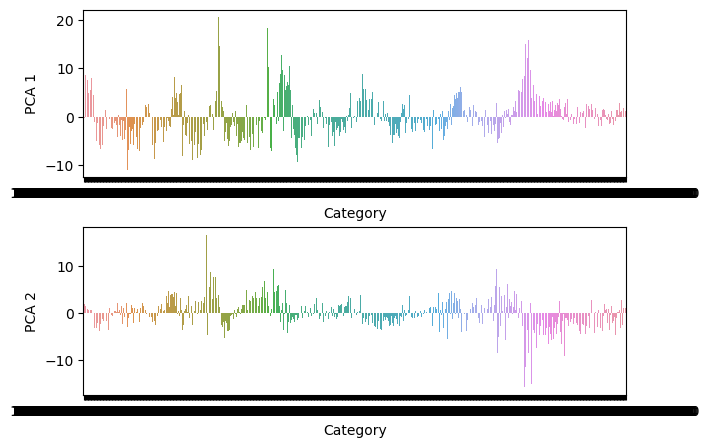

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create a PCA instance: pca
pca = PCA(n_components=15)

# Normalizer
normalizer = StandardScaler(with_mean=True, with_std=True)

data_pca = normalizer.fit_transform(data)

# Fit the PCA instance to the scaled samples
pca.fit(data_pca)

# Get the explained variances from pca
eigen_values = pca.explained_variance_ratio_

# Eigenvectors are the components
eigen_vectors = pca.components_

print("Explained variances: ", eigen_values)
# Transform the scaled samples: pca_features
pca_features = pca.transform(data_pca)

plots = 2
fig, ax = plt.subplots(plots, 1, figsize=(7, 5))
plt.subplots_adjust(hspace=0.3)

for i in range(plots):
    sns.barplot(x = data.index, y=pca_features[:,i], ax=ax[i])
    ax[i].set_xlabel('Category')
    ax[i].set_ylabel('PCA {}'.format(i+1))


In [9]:
def spca_oos(X, target, h_steps=1, test_start='1985-01-01', nfac = 5, scale=True):
    """Out of sample prediction using sPCA"""	

    index_test = data.index.get_loc(test_start)
    T = len(target)

    # Initialize the list of predicted values and actual values
    preds = []
    actuals = []

    # Iterate by an expanding window
    # The first training window is 1960-01-01 to 1985-01-01
    for t in range(index_test, T - h_steps):

        # Split the data into train and test
        X_train, y_train = X[:t], target[:t]
        y_test = target[t]

        # Perform sPCA on the training set to obtain the factors
        factors, _ = sPCAest(y_train, X_train, nfac=nfac)
        
        # Fit the model on the factors obtained on the training set
        lr = LinearRegression(fit_intercept=True)
        lr.fit(factors, y_train)

        # Predict the response variable on the test set for 1 value
        y_pred = lr.predict(factors[-1].reshape(1, -1))

        # Compute the MSE
        preds.append(y_pred)
        actuals.append(y_test)

    return actuals, preds


def spca_is(X, target, nfac=5, scale=True, quantile=[0, 100]):
    """In sample prediction using sPCA"""

    if scale:
        # Obtain factors from sPCA
        factors, eigen_values = sPCAest(target, X, nfac=nfac, quantile=quantile)
    else:
        # Normalize X
        Xs = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

        # Obtain factors from PCA
        pca = PCA(n_components=nfac)
        factors = pca.fit_transform(Xs)
        eigen_values = pca.explained_variance_ratio_

    # Fit the model on the factors obtained on the training set
    lr = LinearRegression(fit_intercept=True)

    lr.fit(factors, target)

    # Predict the response variables on the factors from the training set
    y_pred = lr.predict(factors)

    # Return the true values, predicted values, and eigen values
    return target, y_pred, eigen_values


def compute_R2(actuals, preds, adjusted = True, nfac = None):
    """Compute R2 and adjusted R2"""
     
    if adjusted and nfac is None :
        raise ValueError("Need to give number of factors")
    
    SSR_list = []
    SST_list = []
    mean_actuals = np.mean(actuals)

    for i in range(len(actuals)):
        SSR_list.append((actuals[i] - preds[i])**2)
        SST_list.append((actuals[i] - mean_actuals)**2)

    SSR = np.sum(SSR_list)
    SST = np.sum(SST_list)

    print("SSR: ", SSR, "SST: ", SST)
    R2 = 1 - SSR/SST

    if not adjusted:
        return R2
    else:
        n = len(actuals)
        k = nfac
        R2_adj = 1 - (1 - R2) * (n - 1) / (n - k - 1)
        
        return R2_adj
     

def R2_OS(actuals, forecasts_pca, forecasts_benchmark):
    """Compute R2 for out of sample predictions"""
    
    actuals = np.array(actuals)
    forecasts_pca = np.array(forecasts_pca)
    forecasts_benchmark = np.array(forecasts_benchmark)

    SSR_pca = np.sum((actuals - forecasts_pca)**2)
    SSR_benchmark = np.sum((actuals - forecasts_benchmark)**2)

    R2_os = 1 - SSR_pca/SSR_benchmark
    R2_os = np.round(R2_os * 100, 2)

    return R2_os


def AR_predict(series, max_lags=20):
    ar_preds = np.zeros(len(series))

    for i in range(1,max_lags):
        ar_preds[i] = np.mean(series[:i])

    for i in range(max_lags, len(series)):
        # Choose optimal lag length
        ar = fit_lags(series[:i], 10)
        
        model_fit = ar.fit()    
        ar_preds[i] = model_fit.predict(start=i, end=i)[0]

    return ar_preds
